<a href="https://colab.research.google.com/github/Kidus-Bellete/Cardiovascular-Disease-Prediction-with-Advanced-Machine-Learning-and-Explainable-AI/blob/main/cardiovascular_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
#!pip install shap
#!pip install imblearn

# **Import Necessary Libraries**

In [49]:
# Basic data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Deep learning with TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Model evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)

# Explainable AI
import shap


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [50]:
df = pd.read_csv('/content/drive/MyDrive/XAI/heart_failure_clinical_records_dataset-1-1.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [51]:
df.info()
print("the total number of missing value in each features:")
print(df.isnull().sum())
df_duplicated = df.duplicated().sum()
print(f"Number of duplicate rows: {df_duplicated}")
df = df.drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB
the total number o

In [52]:
df.shape

(299, 13)

In [53]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


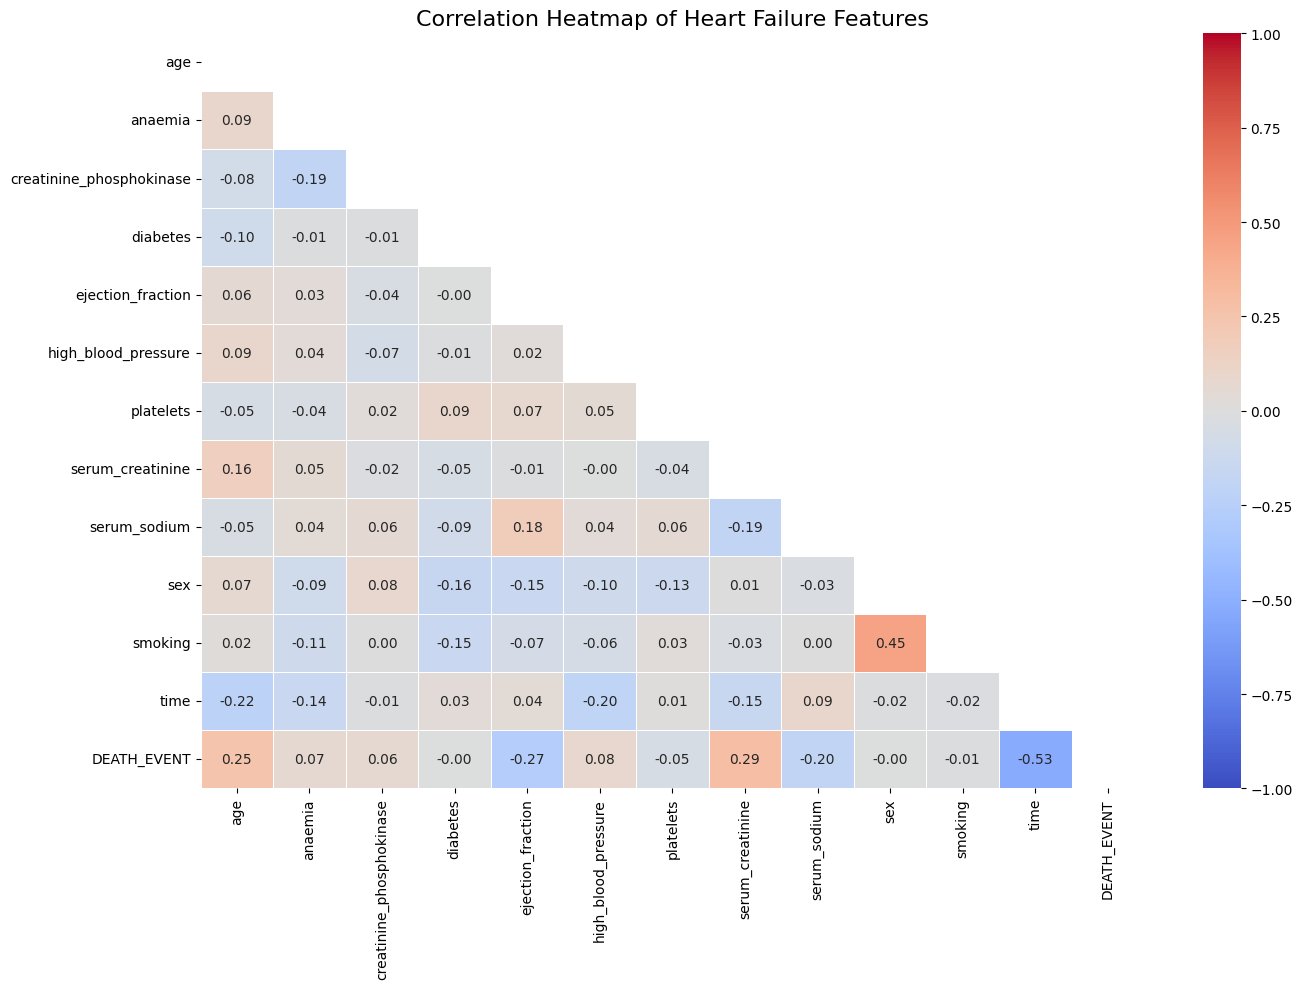

In [54]:
# Correlation Heatmap
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            mask=mask, linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Heart Failure Features', fontsize=16)
plt.tight_layout()
plt.show()


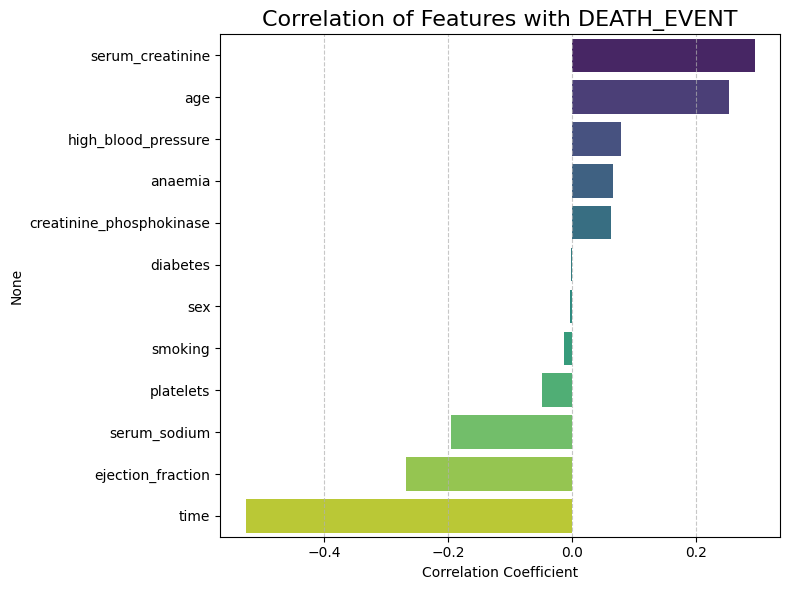

In [55]:
# Correlation with Target Variable (DEATH_EVENT)
plt.figure(figsize=(8, 6))
death_correlation = correlation_matrix['DEATH_EVENT'].drop('DEATH_EVENT').sort_values(ascending=False)
sns.barplot(x=death_correlation.values, y=death_correlation.index, hue=death_correlation.index, palette='viridis', legend=False)
plt.title('Correlation of Features with DEATH_EVENT', fontsize=16)
plt.xlabel('Correlation Coefficient')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

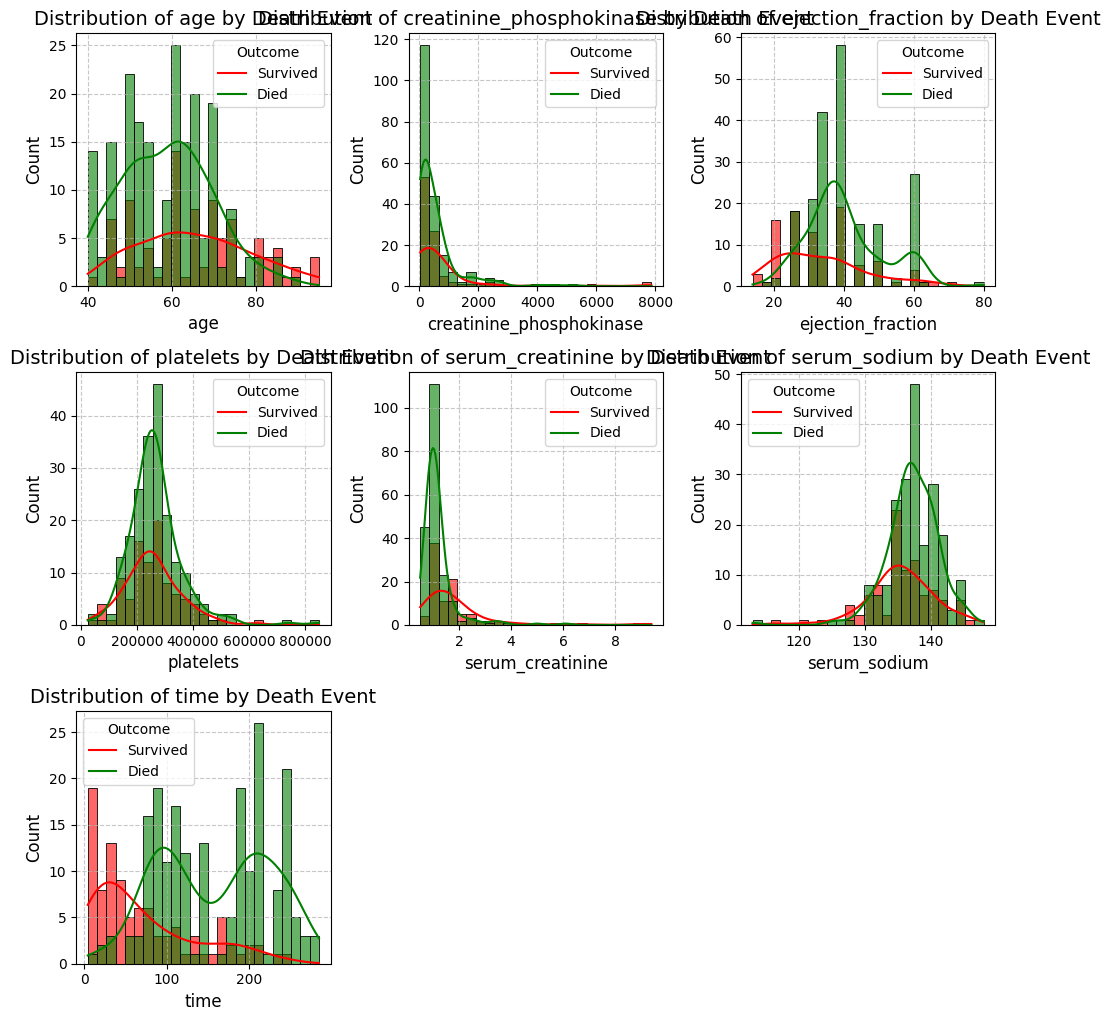

In [56]:
# Distribution of Numerical Features by Death Event
numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction',
                      'platelets', 'serum_creatinine', 'serum_sodium', 'time']

fig, axes = plt.subplots(6, 3, figsize=(10, 20))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    if i < len(axes):
        sns.histplot(data=df, x=feature, hue='DEATH_EVENT', kde=True, bins=25,
                    palette={0: 'green', 1: 'red'}, alpha=0.6, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature} by Death Event', fontsize=14)
        axes[i].set_xlabel(feature, fontsize=12)
        axes[i].set_ylabel('Count', fontsize=12)
        axes[i].legend(['Survived', 'Died'], title='Outcome')
        axes[i].grid(linestyle='--', alpha=0.7)

# Remove any unused subplot
for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

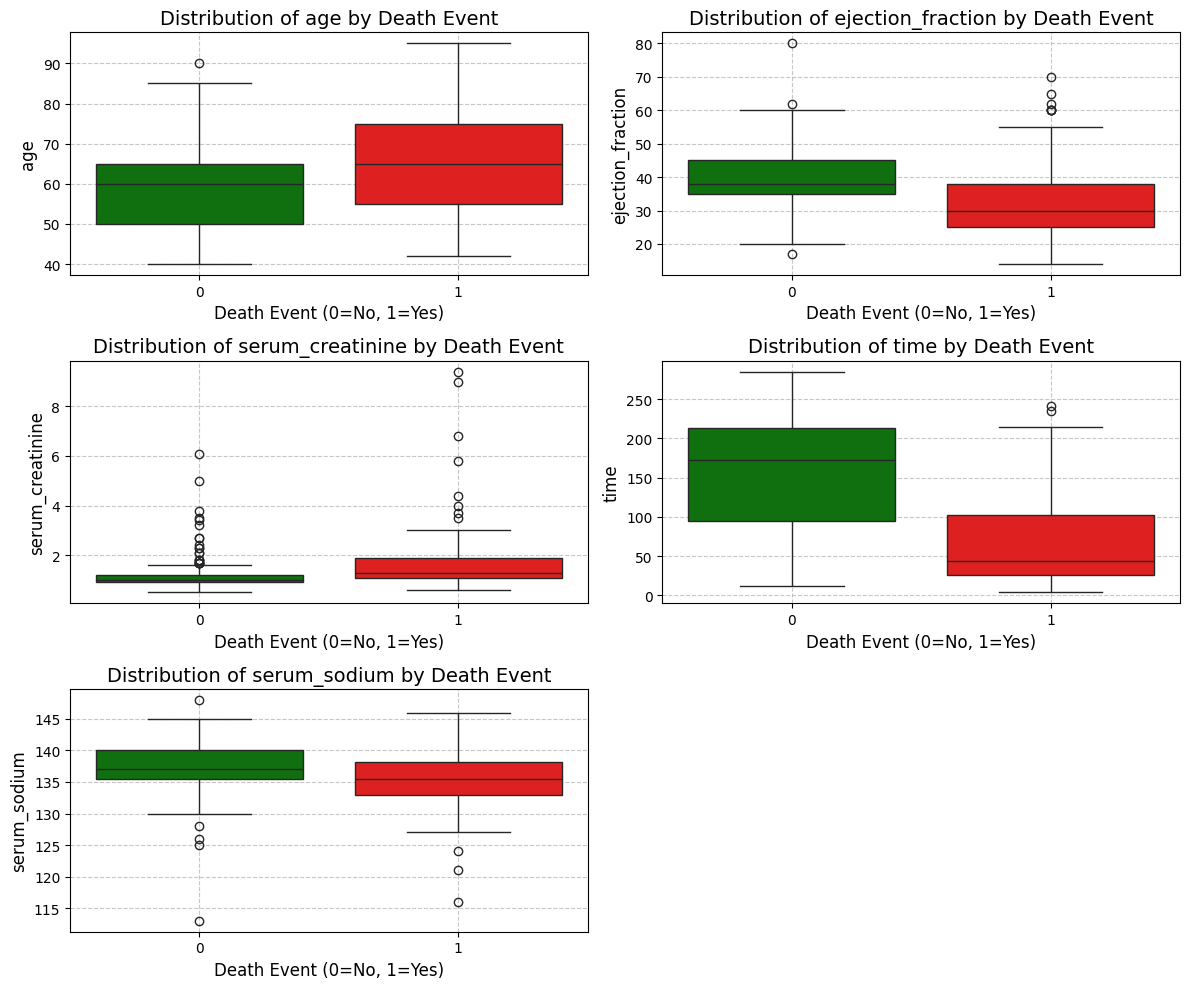

In [57]:
# Boxplots for Key Features by Death Event
key_features = ['age', 'ejection_fraction', 'serum_creatinine', 'time', 'serum_sodium']

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    if i < len(axes):
        sns.boxplot(x='DEATH_EVENT', y=feature, data=df,
                   hue='DEATH_EVENT', palette={0: 'green', 1: 'red'},
                   legend=False, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature} by Death Event', fontsize=14)
        axes[i].set_xlabel('Death Event (0=No, 1=Yes)', fontsize=12)
        axes[i].set_ylabel(feature, fontsize=12)
        axes[i].grid(linestyle='--', alpha=0.7)

# Remove any unused subplot
for i in range(len(key_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

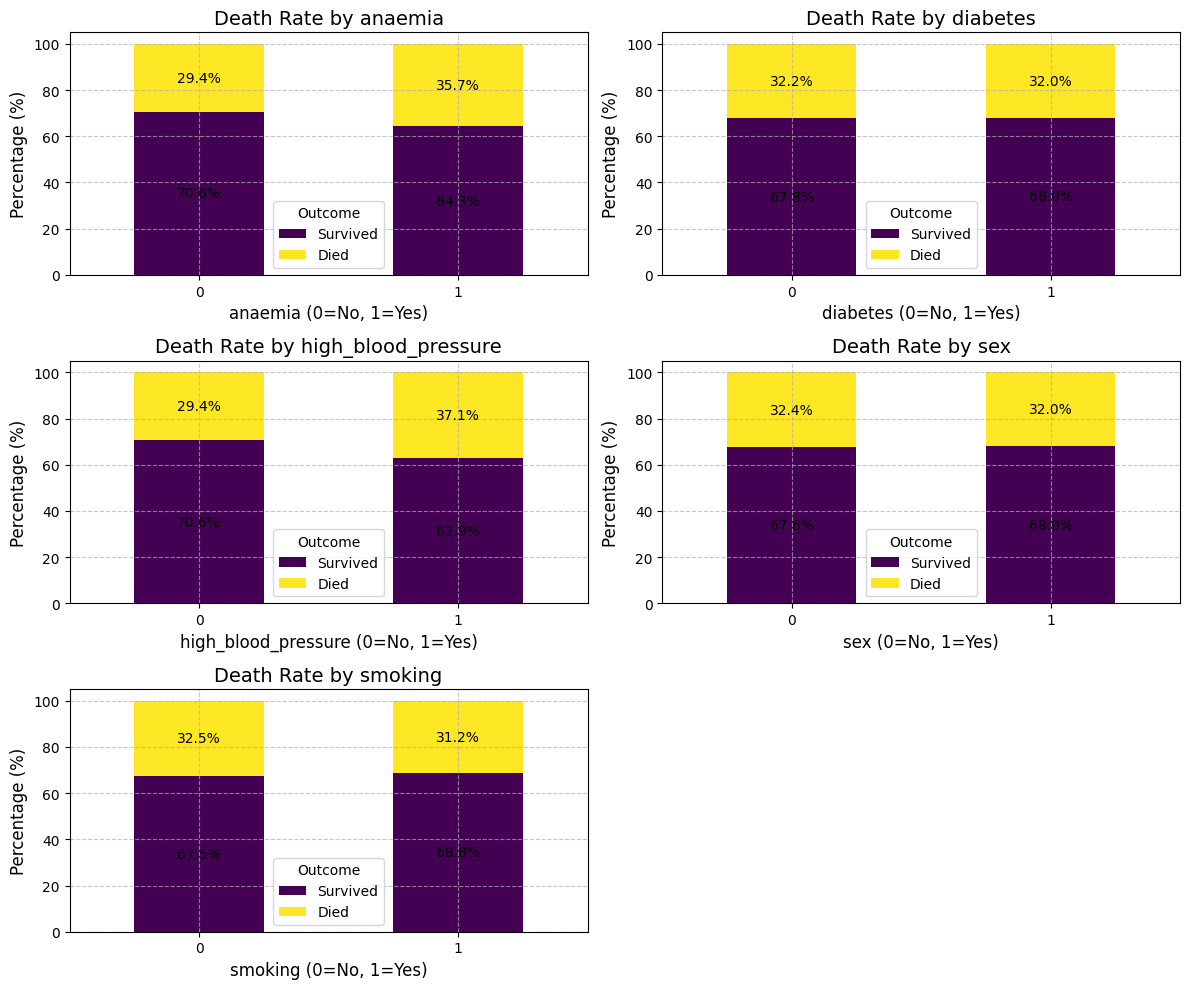

In [58]:
# Categorical Features Analysis
categorical_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    if i < len(axes):
        # Create a cross-tabulation
        cross_tab = pd.crosstab(df[feature], df['DEATH_EVENT'])
        cross_tab_percentage = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

        # Plot stacked bar chart
        cross_tab_percentage.plot(kind='bar', stacked=True,
                                colormap='viridis', ax=axes[i], rot=0)
        axes[i].set_title(f'Death Rate by {feature}', fontsize=14)
        axes[i].set_xlabel(f'{feature} (0=No, 1=Yes)', fontsize=12)
        axes[i].set_ylabel('Percentage (%)', fontsize=12)
        axes[i].legend(['Survived', 'Died'], title='Outcome')
        axes[i].grid(linestyle='--', alpha=0.7)

        # Add percentage labels
        for j, p in enumerate(axes[i].patches):
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy()
            if height > 5:  # Only label if percentage is greater than 5%
                axes[i].text(x + width/2, y + height/2, f'{height:.1f}%',
                            ha='center', va='center')

# Remove any unused subplot
for i in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

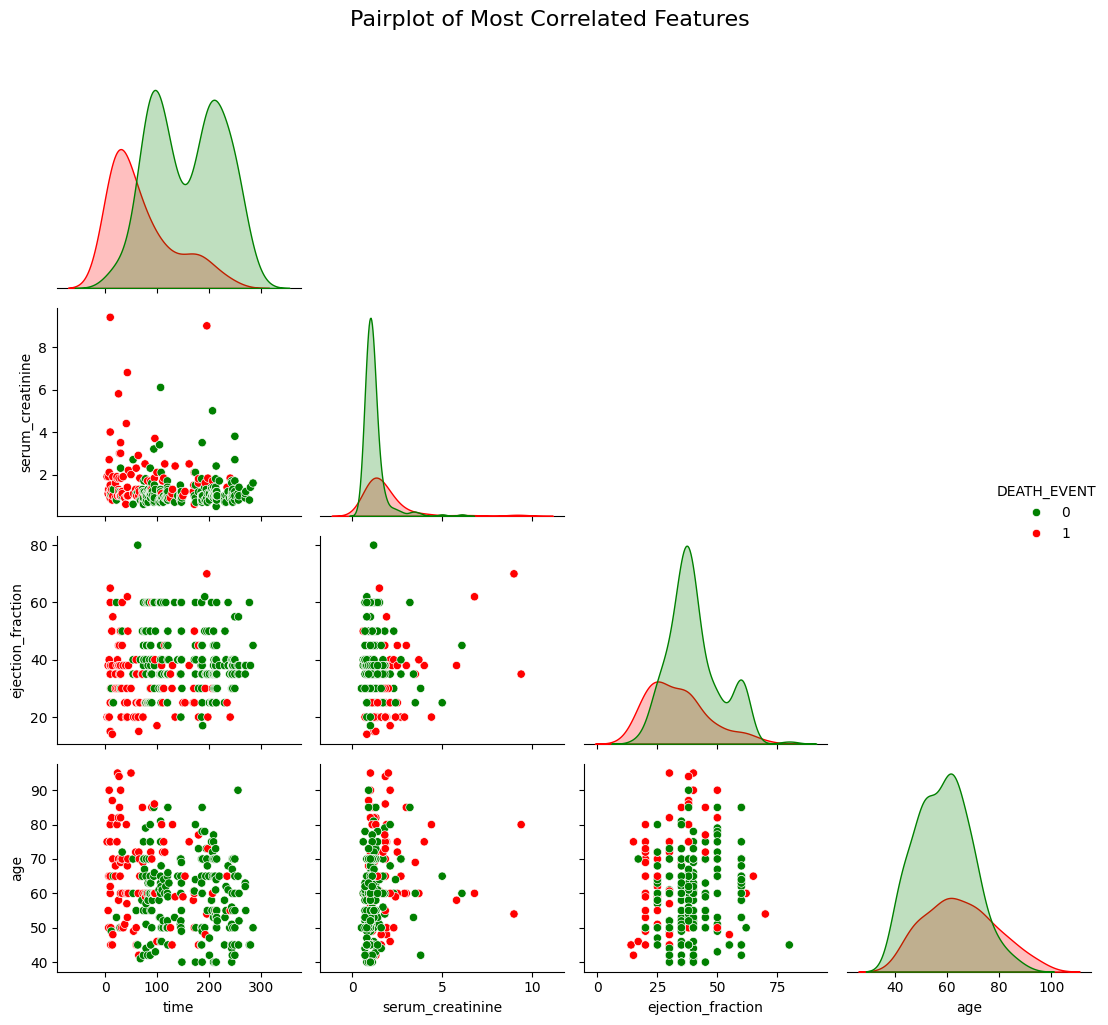

In [59]:
# Pairplot of Most Correlated Features
most_correlated_features = ['time', 'serum_creatinine', 'ejection_fraction', 'age', 'DEATH_EVENT']
sns.pairplot(df[most_correlated_features], hue='DEATH_EVENT',
             palette={0: 'green', 1: 'red'}, corner=True)
plt.suptitle('Pairplot of Most Correlated Features', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

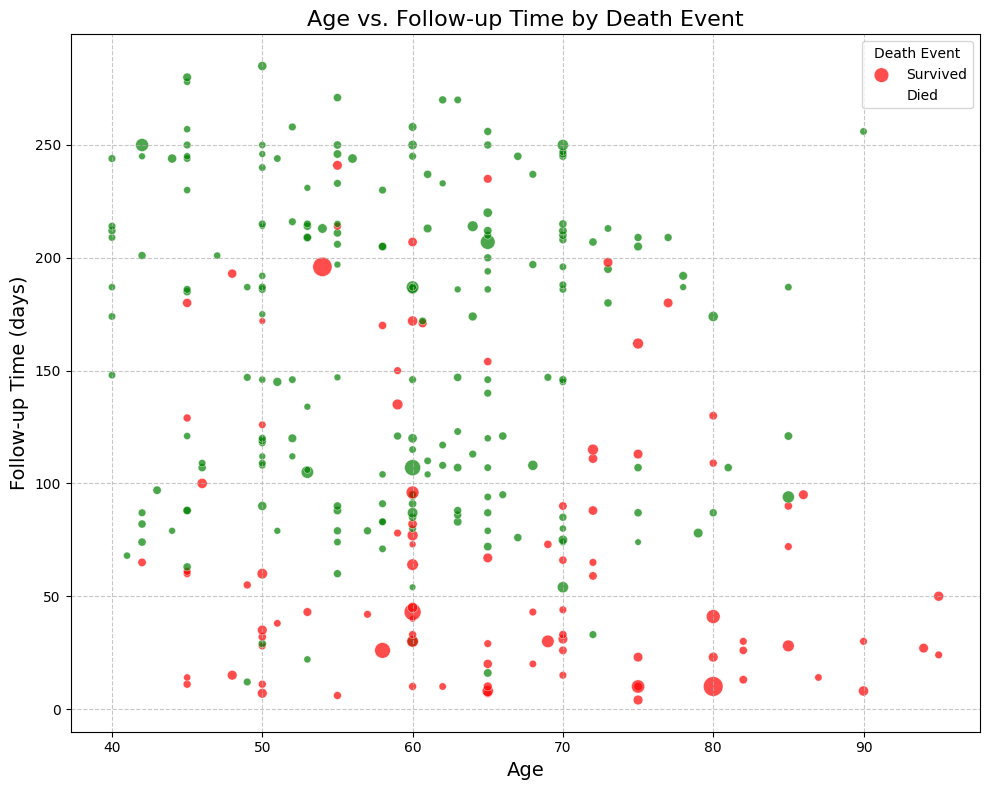

In [60]:
# Age vs Time with Death Event
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='age', y='time', hue='DEATH_EVENT',
               palette={0: 'green', 1: 'red'}, size='serum_creatinine',
               sizes=(20, 200), alpha=0.7)
plt.title('Age vs. Follow-up Time by Death Event', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Follow-up Time (days)', fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title='Death Event', labels=['Survived', 'Died'])
plt.tight_layout()
plt.show()

In [61]:
# List of all continuous variables
continuous_variables = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
                   'serum_creatinine', 'serum_sodium', 'time']
# Standared Scaler
scaler = StandardScaler()
df[continuous_variables] = scaler.fit_transform(df[continuous_variables])

#MnMax Scaler
# minmax_scaler = MinMaxScaler()
# df[continuous_variables] = minmax_scaler.fit_transform(df[continuous_variables])

#Robust Scaler
# robust_scaler = RobustScaler()
# df[continuous_variables] = robust_scaler.fit_transform(df[continuous_variables])

In [62]:
from imblearn.over_sampling import SMOTE
from collections import Counter
# Define features (x) and target (y)
x = df.iloc[:, :-1].values  # All columns except the last one (DEATH_EVENT)
y = df.iloc[:, -1].values   # The last column (DEATH_EVENT)

# Check class distribution before SMOTE
counter_before = Counter(y)
print(f'Class distribution before SMOTE: {counter_before}')

# Apply SMOTE to balance the classes in DEATH_EVENT
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

# Check class distribution after SMOTE
counter_after = Counter(y)
print(f'Class distribution after SMOTE: {counter_after}')

# Split the data into training (70%) , val(15%) and tset(15%)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.30, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.50, random_state=42)

# Print the shapes of the datasets
print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape: {x_test.shape}")

Class distribution before SMOTE: Counter({0: 203, 1: 96})
Class distribution after SMOTE: Counter({1: 203, 0: 203})
Training set shape: (284, 12)
Validation set shape: (61, 12)
Test set shape: (61, 12)



LOGISTIC REGRESSION MODEL

Logistic Regression Evaluation Results
              precision    recall  f1-score   support

    No Death       0.79      0.91      0.85        33
       Death       0.87      0.71      0.78        28

    accuracy                           0.82        61
   macro avg       0.83      0.81      0.81        61
weighted avg       0.83      0.82      0.82        61

Accuracy: 0.8197
Precision: 0.8696
Recall: 0.7143
F1: 0.7843
ROC AUC: 0.9069

RANDOM FOREST MODEL

Random Forest Evaluation Results
              precision    recall  f1-score   support

    No Death       0.86      0.94      0.90        33
       Death       0.92      0.82      0.87        28

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.88        61

Accuracy: 0.8852
Precision: 0.9200
Recall: 0.8214
F1: 0.8679
ROC AUC: 0.9248


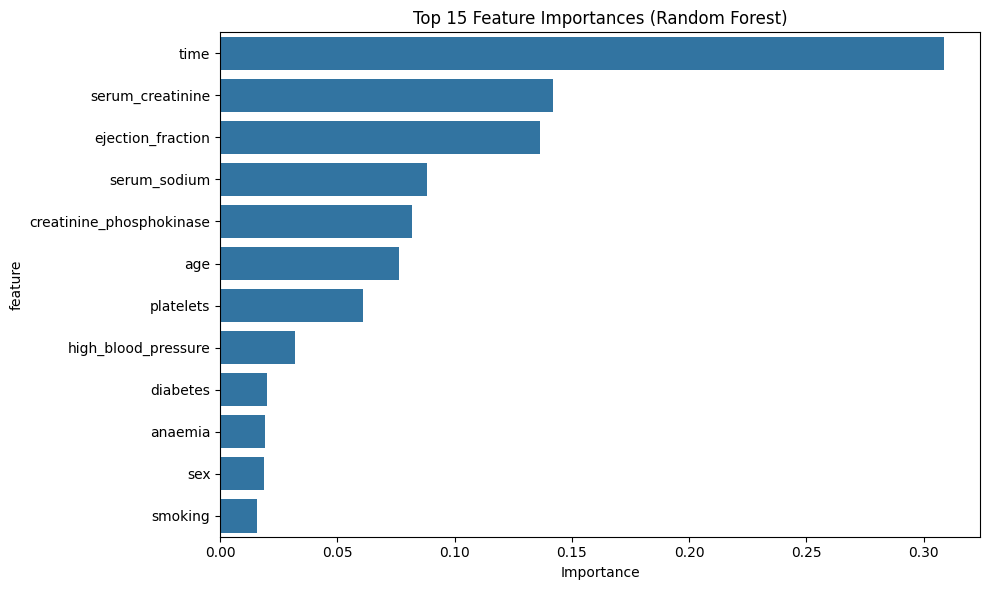


Top 10 Most Important Features:
                 feature  importance
                    time    0.308583
        serum_creatinine    0.142027
       ejection_fraction    0.136458
            serum_sodium    0.088392
creatinine_phosphokinase    0.081910
                     age    0.076201
               platelets    0.060807
     high_blood_pressure    0.032093
                diabetes    0.020116
                 anaemia    0.019139

MODEL COMPARISON

Performance Comparison:
              Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
Logistic Regression    0.8197     0.8696  0.7143    0.7843   0.9069
      Random Forest    0.8852     0.9200  0.8214    0.8679   0.9248


In [63]:
# ML Models (Logistic Regression, Random Forest)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, classification_report)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize data for Logistic Regression
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    """
    Comprehensive evaluation function for ML models
    """
    # Train model
    model.fit(X_train, y_train)

    # Generate predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }

    # Print results
    print(f"\n{'='*40}")
    print(f"{model_name} Evaluation Results")
    print('='*40)
    print(classification_report(y_test, y_pred, target_names=['No Death', 'Death']))

    for metric, value in metrics.items():
        if value is not None:
            print(f"{metric}: {value:.4f}")

    return metrics

# =============================================
# Logistic Regression
# =============================================
print("\n" + "="*60)
print("LOGISTIC REGRESSION MODEL")
print("="*60)

logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg_metrics = evaluate_model(
    logreg,
    "Logistic Regression",
    x_train_scaled, y_train,
    x_test_scaled, y_test
)

# =============================================
# Random Forest
# =============================================
print("\n" + "="*60)
print("RANDOM FOREST MODEL")
print("="*60)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_metrics = evaluate_model(
    rf_model,
    "Random Forest",
    x_train, y_train,  # Random Forest doesn't require scaling
    x_test, y_test
)

# Feature importance visualization
X = df.drop('DEATH_EVENT', axis=1)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# =============================================
# Model Comparison
# =============================================
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

# Create comparison dataframe
comparison_data = {
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [
        logreg_metrics['Accuracy'],
        rf_metrics['Accuracy']
    ],
    'Precision': [
        logreg_metrics['Precision'],
        rf_metrics['Precision']
    ],
    'Recall': [
        logreg_metrics['Recall'],
        rf_metrics['Recall']
    ],
    'F1 Score': [
        logreg_metrics['F1'],
        rf_metrics['F1']
    ],
    'ROC AUC': [
        logreg_metrics['ROC AUC'],
        rf_metrics['ROC AUC']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nPerformance Comparison:")
print(comparison_df.round(4).to_string(index=False))

In [64]:
# Neural Network Notebook

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Main Network Architecture
def build_simple_nn(input_dim, architecture='medium'):
    model = Sequential()

    if architecture == 'small':
        # Small architecture
        model.add(Dense(32, activation='relu', input_shape=(input_dim,)))
        model.add(Dropout(0.3))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))

    elif architecture == 'medium':
        # Medium architecture
        model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(32, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))

    elif architecture == 'large':
        # Larger architecture
        model.add(Dense(128, activation='relu', input_shape=(input_dim,)))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))

    # Compile model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.AUC(name='auc'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])
    return model

def build_cnn_model(input_dim):
    """
    Build a 1D CNN model for tabular data
    """
    model = Sequential()

    # Reshape input for 1D CNN (samples, features, 1)
    model.add(tf.keras.layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

    # First Conv1D block
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.5))

    # Second Conv1D block
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.5))

    # Third Conv1D block
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.AUC(name='auc'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])
    return model

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Train models with different architectures
architectures = ['small', 'medium', 'large', 'cnn']
models = {}
histories = {}
weighted_models = {}  # New dictionary for weighted models
weighted_histories = {}  # New dictionary for weighted histories

for arch in architectures:
    print(f"\n{'='*50}")
    print(f"Training {arch.upper()} {'CNN' if arch == 'cnn' else 'Neural Network'}")
    print(f"{'='*50}")

    # Build model
    if arch == 'cnn':
        model = build_cnn_model(x_train.shape[1])
    else:
        model = build_simple_nn(x_train.shape[1], arch)

    model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_auc', patience=20, mode='max', restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=10, min_lr=1e-6, verbose=1)
    ]

    # Train standard model
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=50,
        batch_size=16,
        callbacks=callbacks,
        verbose=1
    )

    models[arch] = model
    histories[arch] = history

    # Train weighted version (except for CNN)
    if arch != 'cnn':
        print(f"\nTraining WEIGHTED {arch.upper()} Neural Network")
        weighted_model = build_simple_nn(x_train.shape[1], arch)

        weighted_history = weighted_model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=50,
            batch_size=16,
            callbacks=callbacks,
            class_weight=class_weight_dict,
            verbose=1
        )

        weighted_models[f'{arch}_weighted'] = weighted_model
        weighted_histories[f'{arch}_weighted'] = weighted_history


Training SMALL Neural Network


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                     │ (None, 32)                  │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 961 (3.75 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.4852 - auc: 0.4864 - loss: 0.7546 - precision: 0.4893 - recall: 0.4336 - val_accuracy: 0.5738 - val_auc: 0.6948 - val_loss: 0.6793 - val_precision: 0.7619 - val_recall: 0.4324 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5859 - auc: 0.6279 - loss: 0.6679 - precision: 0.6071 - recall: 0.5131 - val_accuracy: 0.6230 - val_auc: 0.7494 - val_loss: 0.6585 - val_precision: 0.8182 - val_recall: 0.4865 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5690 - auc: 0.5936 - loss: 0.6962 - precision: 0.5848 - recall: 0.4873 - val_accuracy: 0.6885 - val_auc: 0.7691 - val_loss: 0.6366 - val_precision: 0.8462 - val_recall: 0.5946 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6369 - auc: 0.7317 - loss: 0.6202 - precision: 0.6973 - recall: 0.4960 - val_accuracy: 0.7049 - val_auc: 0.7838 - val_loss: 0.6188 - val_pr

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                     │ (None, 64)                  │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,841 (15.00 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 423ms/step - accuracy: 0.3994 - auc: 0.3633 - loss: 1.0824 - precision: 0.3706 - recall: 0.2691 - val_accuracy: 0.3115 - val_auc: 0.2432 - val_loss: 0.7888 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5563 - auc: 0.5487 - loss: 0.8933 - precision: 0.5713 - recall: 0.4927 - val_accuracy: 0.4754 - val_auc: 0.3553 - val_loss: 0.7355 - val_precision: 0.6190 - val_recall: 0.3514 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5351 - auc: 0.5689 - loss: 0.8306 - precision: 0.5428 - recall: 0.4452 - val_accuracy: 0.6066 - val_auc: 0.5648 - val_loss: 0.6909 - val_precision: 0.7407 - val_recall: 0.5405 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6242 - auc: 0.6894 - loss: 0.6688 - precision: 0.6467 - recall: 0.5636 - val_accuracy: 0.6721 - val_auc: 0.6869 - val_loss: 0.6598 -

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_68 (Dense)                     │ (None, 128)                 │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,313 (52.00 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 259ms/step - accuracy: 0.5022 - auc: 0.4999 - loss: 0.9300 - precision: 0.5087 - recall: 0.3617 - val_accuracy: 0.4590 - val_auc: 0.4994 - val_loss: 0.6941 - val_precision: 0.5769 - val_recall: 0.4054 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5181 - auc: 0.5505 - loss: 0.8382 - precision: 0.5381 - recall: 0.3361 - val_accuracy: 0.6066 - val_auc: 0.5845 - val_loss: 0.6889 - val_precision: 0.6512 - val_recall: 0.7568 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5207 - auc: 0.5468 - loss: 0.8041 - precision: 0.5295 - recall: 0.4196 - val_accuracy: 0.6066 - val_auc: 0.6104 - val_loss: 0.6869 - val_precision: 0.6512 - val_recall: 0.7568 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6235 - auc: 0.6783 - loss: 0.7129 - precision: 0.6617 - recall: 0.4932 - val_accuracy: 0.6721 - val_auc: 0.6926 - val_loss: 0.6819 - val_prec

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)                  │ (None, 12, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 12, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 12, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 12, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 6, 32)               │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 6, 32)               │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 6, 32)               │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 3, 16)               │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 3, 16)               │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 3, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 64)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 29,393 (114.82 KB)

 Trainable params: 29,041 (113.44 KB)

 Non-trainable params: 352 (1.38 KB)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 361ms/step - accuracy: 0.4733 - auc: 0.5258 - loss: 0.8763 - precision: 0.4810 - recall: 0.5614 - val_accuracy: 0.4426 - val_auc: 0.6188 - val_loss: 0.6940 - val_precision: 1.0000 - val_recall: 0.0811 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5780 - auc: 0.5843 - loss: 0.7673 - precision: 0.5857 - recall: 0.5731 - val_accuracy: 0.3934 - val_auc: 0.6368 - val_loss: 0.7027 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5601 - auc: 0.5802 - loss: 0.7574 - precision: 0.5645 - recall: 0.5601 - val_accuracy: 0.3934 - val_auc: 0.6430 - val_loss: 0.7121 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5459 - auc: 0.5593 - loss: 0.7940 - precision: 0.5517 - recall: 0.5374 - val_accuracy: 0.3934 - val_auc: 0.6250 - val_loss:


Logistic Regression (ML) Evaluation
              precision    recall  f1-score   support

    No Death       0.81      0.88      0.84        33
       Death       0.84      0.75      0.79        28

    accuracy                           0.82        61
   macro avg       0.82      0.81      0.82        61
weighted avg       0.82      0.82      0.82        61

Accuracy: 0.8197
Precision: 0.8400
Recall: 0.7500
F1: 0.7925
ROC AUC: 0.9102
PR AUC: 0.8986

Random Forest (ML) Evaluation
              precision    recall  f1-score   support

    No Death       0.86      0.94      0.90        33
       Death       0.92      0.82      0.87        28

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.88        61

Accuracy: 0.8852
Precision: 0.9200
Recall: 0.8214
F1: 0.8679
ROC AUC: 0.9248
PR AUC: 0.9292

Small NN (Neural Network) Evaluation
              precision    recall  f1-score   support

 

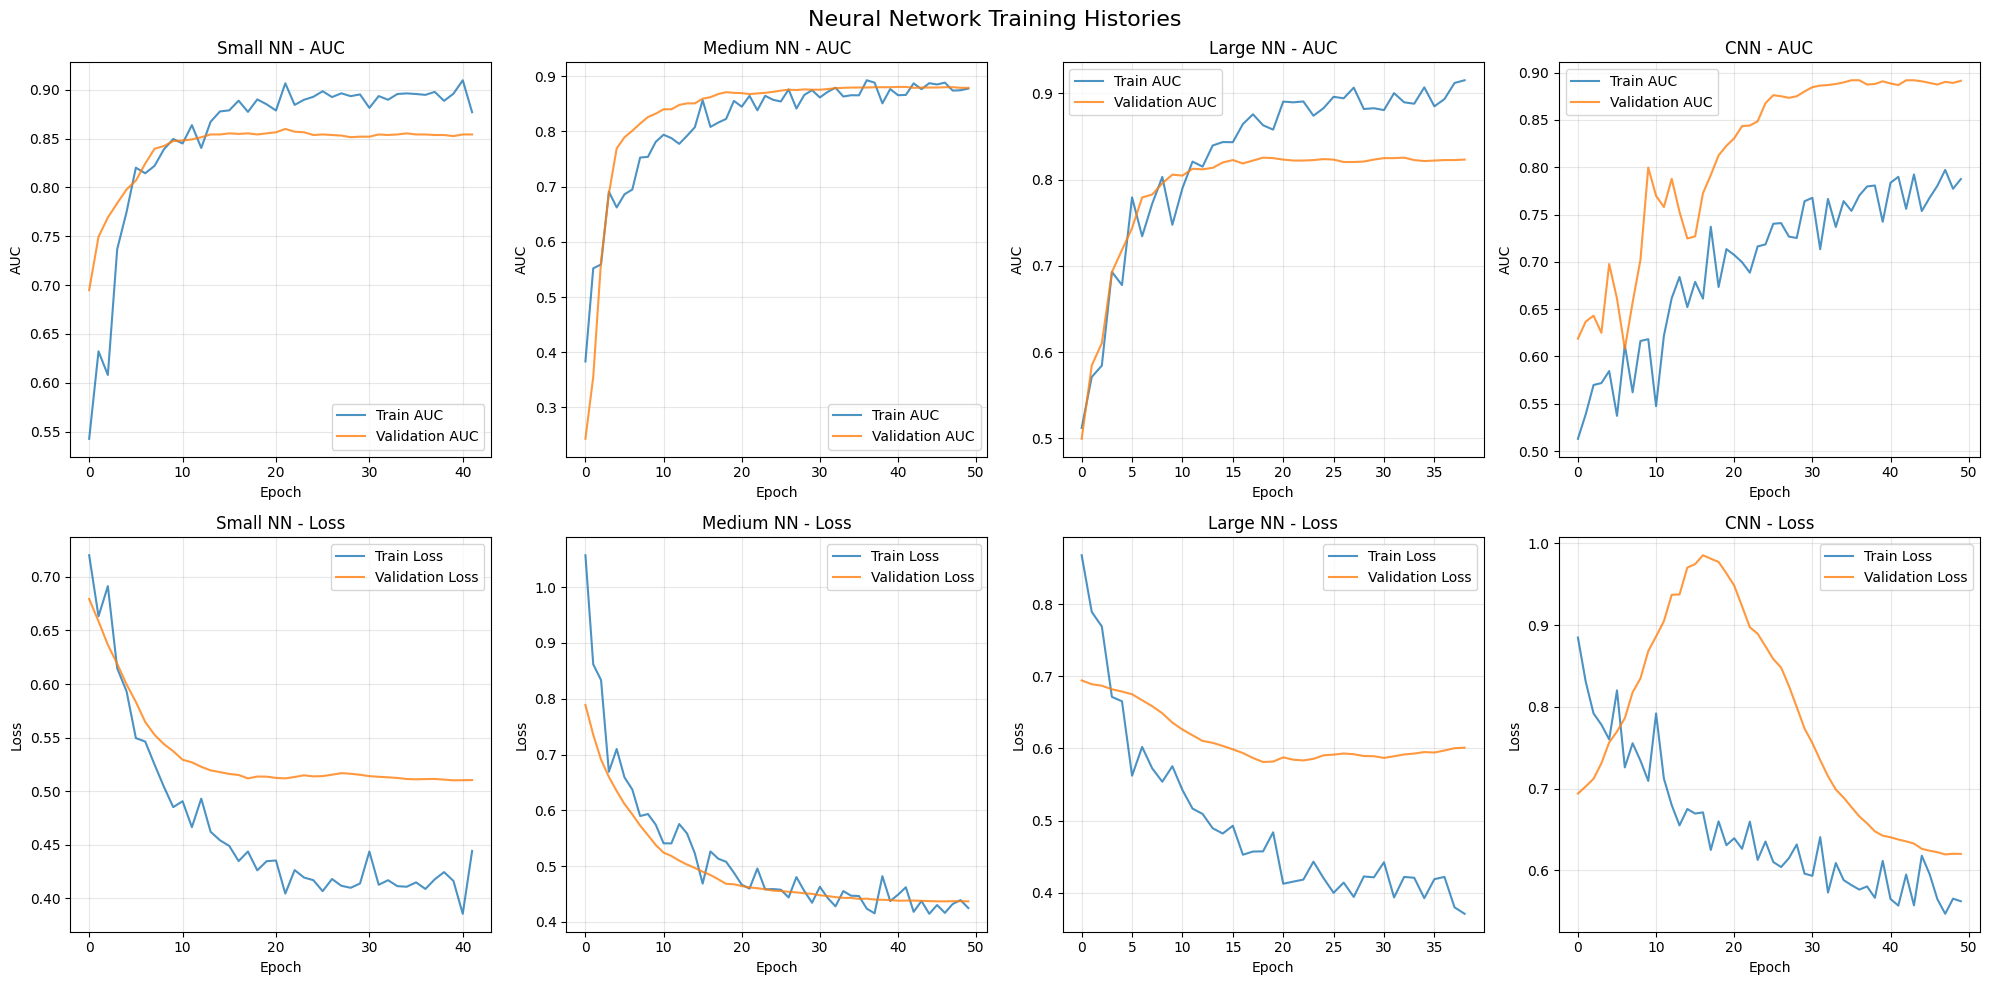

In [65]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_curve, roc_auc_score, classification_report,
                            confusion_matrix, precision_recall_curve, average_precision_score)
from sklearn.utils.class_weight import compute_class_weight

# =============================================
# 1. Evaluation Functions
# =============================================

def evaluate_ml_model(model, X, y, model_name, model_type="ML"):
    """
    Evaluate traditional ML models (Logistic Regression, SVM, Random Forest)
    """
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = model.predict(X)

    # Metrics
    metrics = {
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1': f1_score(y, y_pred),
        'ROC AUC': roc_auc_score(y, y_prob),
        'PR AUC': average_precision_score(y, y_prob)
    }

    # Print report
    print(f"\n{'='*60}")
    print(f"{model_name} ({model_type}) Evaluation")
    print('='*60)
    print(classification_report(y, y_pred, target_names=['No Death', 'Death']))

    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return metrics, y_prob, y_pred

def evaluate_nn_model(model, X, y, model_name):
    """
    Evaluate neural network models
    """
    y_prob = model.predict(X, verbose=0).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    # Metrics
    metrics = {
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1': f1_score(y, y_pred),
        'ROC AUC': roc_auc_score(y, y_prob),
        'PR AUC': average_precision_score(y, y_prob)
    }

    # Print report
    print(f"\n{'='*60}")
    print(f"{model_name} (Neural Network) Evaluation")
    print('='*60)
    print(classification_report(y, y_pred, target_names=['No Death', 'Death']))

    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return metrics, y_prob, y_pred

# =============================================
# 2. Visualization Functions
# =============================================

# def plot_confusion_matrix(y_true, y_pred, model_name):
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(6, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=['No Death', 'Death'],
#                 yticklabels=['No Death', 'Death'])
#     plt.title(f'{model_name} - Confusion Matrix')
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.show()

def plot_roc_curves(results_dict):
    plt.figure(figsize=(10, 8))
    for name, data in results_dict.items():
        fpr, tpr, _ = roc_curve(data['y_true'], data['y_prob'])
        auc_score = roc_auc_score(data['y_true'], data['y_prob'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_pr_curves(results_dict):
    plt.figure(figsize=(10, 8))
    for name, data in results_dict.items():
        precision, recall, _ = precision_recall_curve(data['y_true'], data['y_prob'])
        ap_score = average_precision_score(data['y_true'], data['y_prob'])
        plt.plot(recall, precision, label=f'{name} (AP = {ap_score:.3f})', linewidth=2)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_metric_comparison(comparison_df):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'PR AUC']
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 3, i)
        sns.barplot(data=comparison_df, x=metric, y='Model')
        plt.title(metric)
    plt.tight_layout()
    plt.show()

# =============================================
# 3. Main Evaluation Section
# =============================================

# Initialize storage for results
all_results = {}
comparison_data = []

# Evaluate ML Models (assuming they're trained in Notebook 1)
ml_models = {
    'Logistic Regression': logreg,
    'Random Forest': rf_model
}

for name, model in ml_models.items():
    metrics, y_prob, y_pred = evaluate_ml_model(model, x_test, y_test, name)
    all_results[name] = {'y_true': y_test, 'y_prob': y_prob, 'y_pred': y_pred}
    comparison_data.append({'Model': name, **metrics})

    # Plot confusion matrix
    #plot_confusion_matrix(y_test, y_pred, name)

# Evaluate Neural Networks (assuming they're trained in Notebook 2)
nn_models = {
    'Small NN': models['small'],
    'Medium NN': models['medium'],
    'Large NN': models['large'],
    'CNN': models['cnn']
}

for name, model in nn_models.items():
    metrics, y_prob, y_pred = evaluate_nn_model(model, x_test, y_test, name)
    all_results[name] = {'y_true': y_test, 'y_prob': y_prob, 'y_pred': y_pred}
    comparison_data.append({'Model': name, **metrics})

    # Plot confusion matrix
    #plot_confusion_matrix(y_test, y_pred, name)

# Evaluate Weighted Neural Networks (if available)
if 'weighted_models' in globals():
    weighted_nn_models = {
        'Small NN (Weighted)': weighted_models['small_weighted'],
        'Medium NN (Weighted)': weighted_models['medium_weighted'],
        'Large NN (Weighted)': weighted_models['large_weighted']
    }

    for name, model in weighted_nn_models.items():
        metrics, y_prob, y_pred = evaluate_nn_model(model, x_test, y_test, name)
        all_results[name] = {'y_true': y_test, 'y_prob': y_prob, 'y_pred': y_pred}
        comparison_data.append({'Model': name, **metrics})

        # Plot confusion matrix
        #plot_confusion_matrix(y_test, y_pred, name)

# =============================================
# 4. Comprehensive Comparison
# =============================================

# Create comparison dataframe
comparison_df = pd.DataFrame(comparison_data)

# Display comparison table
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.round(4).to_string(index=False))

# Visual comparisons
#plot_metric_comparison(comparison_df)
#plot_roc_curves(all_results)
#plot_pr_curves(all_results)

# =============================================
# 5. Neural Network Training Analysis
# =============================================

if 'histories' in globals():
    # Plot training histories for neural networks
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Neural Network Training Histories', fontsize=16)

    for i, (arch, history) in enumerate(histories.items()):
        # AUC plot
        axes[0, i].plot(history.history['auc'], label='Train AUC', alpha=0.8)
        axes[0, i].plot(history.history['val_auc'], label='Validation AUC', alpha=0.8)
        model_name = 'CNN' if arch == 'cnn' else f'{arch.capitalize()} NN'
        axes[0, i].set_title(f'{model_name} - AUC')
        axes[0, i].set_ylabel('AUC')
        axes[0, i].set_xlabel('Epoch')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)

        # Loss plot
        axes[1, i].plot(history.history['loss'], label='Train Loss', alpha=0.8)
        axes[1, i].plot(history.history['val_loss'], label='Validation Loss', alpha=0.8)
        axes[1, i].set_title(f'{model_name} - Loss')
        axes[1, i].set_ylabel('Loss')
        axes[1, i].set_xlabel('Epoch')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [66]:
#!pip install lime

COMPLETE XAI ANALYSIS - SHAP + LIME + PERMUTATION FOR ALL MODELS
Feature names: ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']
Number of features: 12

STEP 1: RUNNING ALL XAI METHODS FOR ALL MODELS

ANALYZING: SMALL NEURAL NETWORK

Calculating Permutation Importance - Small Neural Network
   Baseline ROC-AUC: 0.8983
  Top 3 features: time, ejection_fraction, serum_creatinine

SHAP Analysis - Small Neural Network
  Using KernelExplainer for neural network...


  0%|          | 0/30 [00:00<?, ?it/s]

   SHAP completed. Top feature: time

 LIME Analysis - Small Neural Network
   LIME completed. Top feature: time

ANALYZING: MEDIUM NEURAL NETWORK

Calculating Permutation Importance - Medium Neural Network
   Baseline ROC-AUC: 0.9242
  Top 3 features: time, ejection_fraction, serum_sodium

SHAP Analysis - Medium Neural Network
  Using KernelExplainer for neural network...


  0%|          | 0/30 [00:00<?, ?it/s]

   SHAP completed. Top feature: time

 LIME Analysis - Medium Neural Network
   LIME completed. Top feature: time

ANALYZING: LARGE NEURAL NETWORK

Calculating Permutation Importance - Large Neural Network
   Baseline ROC-AUC: 0.9037
  Top 3 features: time, ejection_fraction, creatinine_phosphokinase

SHAP Analysis - Large Neural Network
  Using KernelExplainer for neural network...


  0%|          | 0/30 [00:00<?, ?it/s]

   SHAP completed. Top feature: time

 LIME Analysis - Large Neural Network
   LIME completed. Top feature: time

ANALYZING: CNN

Calculating Permutation Importance - CNN
   Baseline ROC-AUC: 0.7846
  Top 3 features: time, ejection_fraction, age

SHAP Analysis - CNN
  Using KernelExplainer for neural network...


  0%|          | 0/30 [00:00<?, ?it/s]

   SHAP completed. Top feature: time

 LIME Analysis - CNN
   LIME completed. Top feature: serum_sodium

ANALYZING: RANDOM FOREST

Calculating Permutation Importance - Random Forest
   Baseline ROC-AUC: 0.9248
  Top 3 features: time, ejection_fraction, serum_creatinine

SHAP Analysis - Random Forest
   SHAP failed: Per-column arrays must each be 1-dimensional

 LIME Analysis - Random Forest
   LIME completed. Top feature: time

ANALYZING: LOGISTIC REGRESSION

Calculating Permutation Importance - Logistic Regression
   Baseline ROC-AUC: 0.9102
  Top 3 features: time, ejection_fraction, age

SHAP Analysis - Logistic Regression
   SHAP completed. Top feature: time

 LIME Analysis - Logistic Regression
   LIME completed. Top feature: time

STEP 2: COMPREHENSIVE CROSS-METHOD COMPARISON

 COMPREHENSIVE RESULTS SUMMARY

 Successfully completed analysis:
   • Permutation Importance: 6/6 models
   • SHAP Analysis: 5/6 models
   • LIME Analysis: 6/6 models

 TOP 10 FEATURES - MULTI-METHOD CONSEN

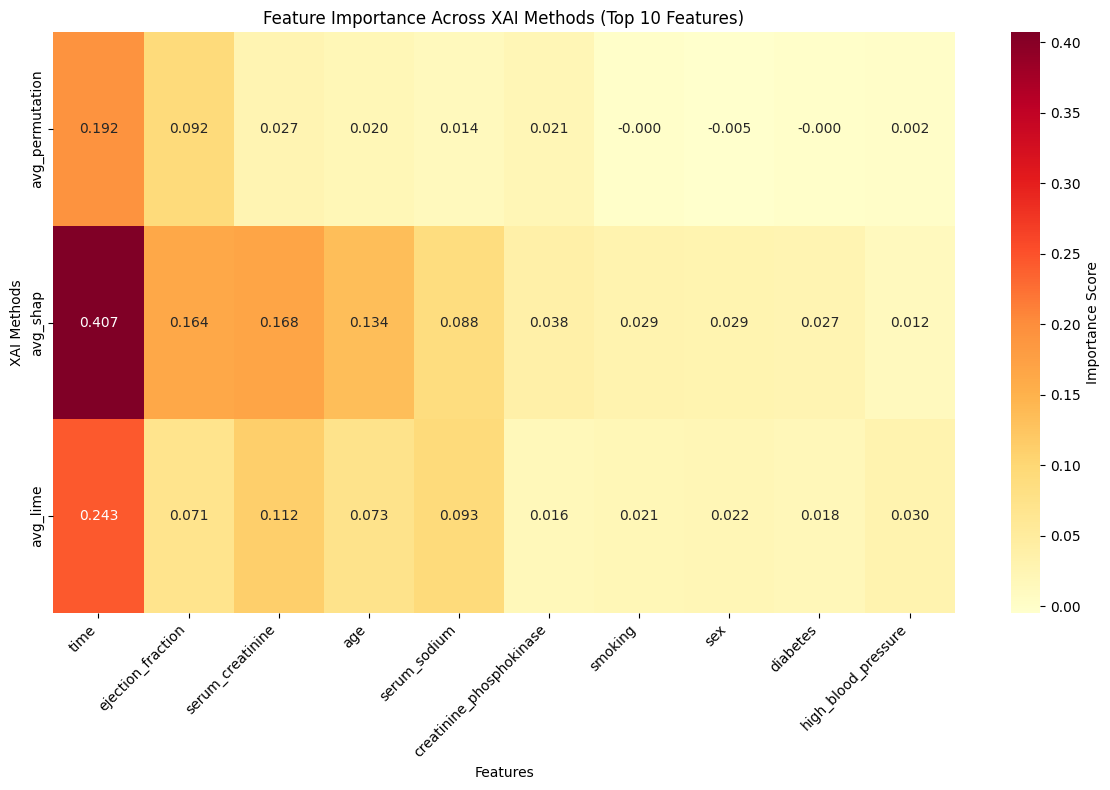

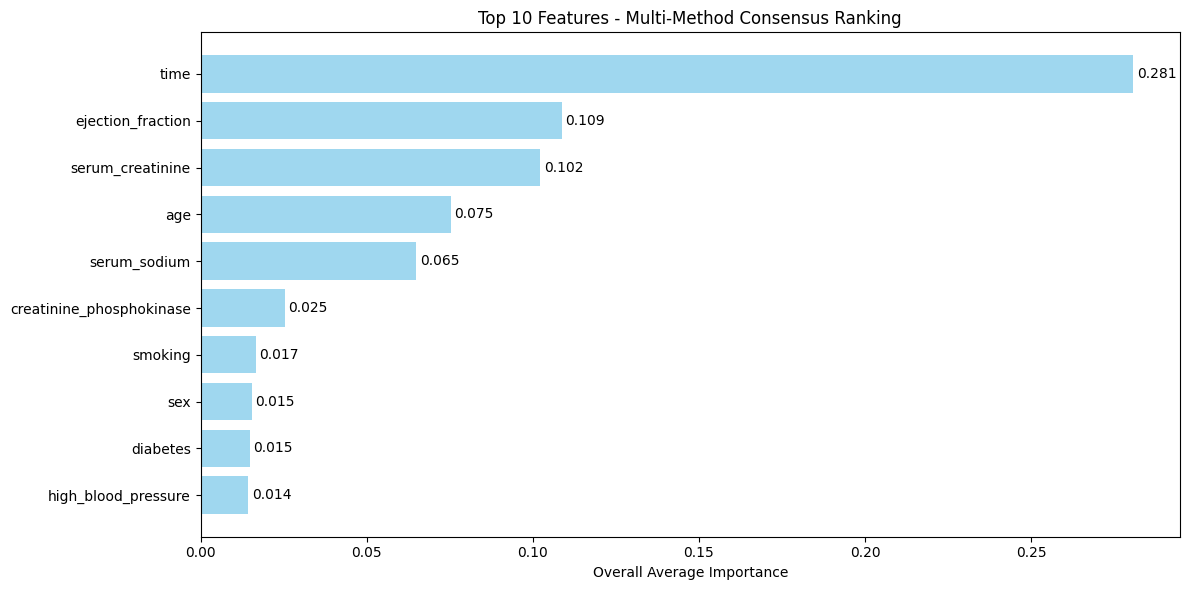


 SHAP SUMMARY PLOTS:


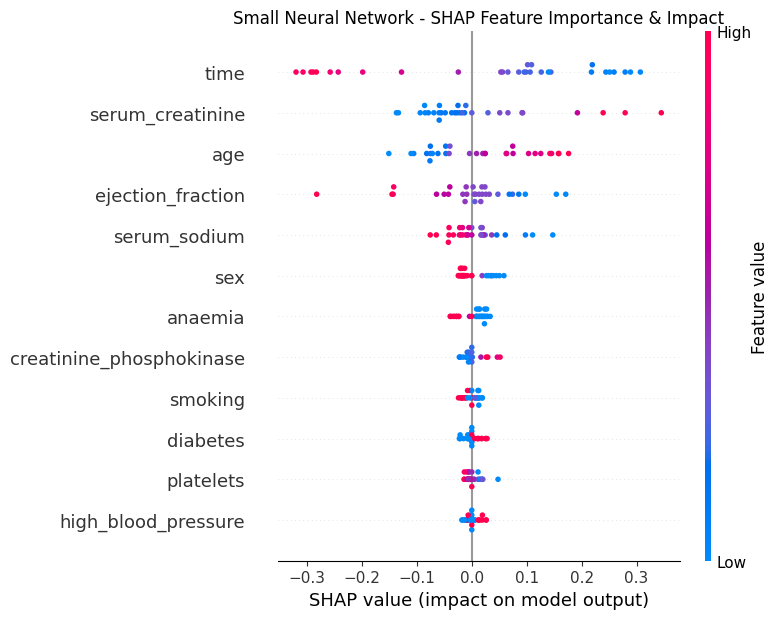

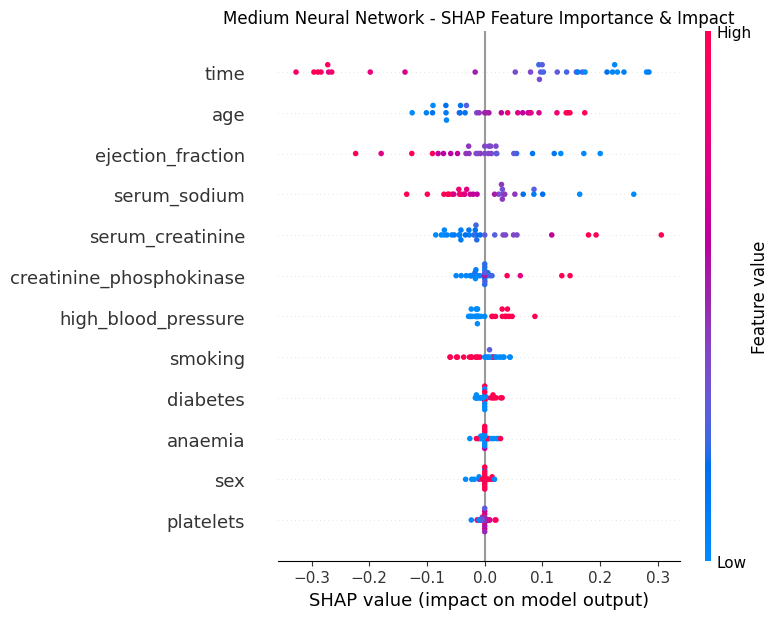

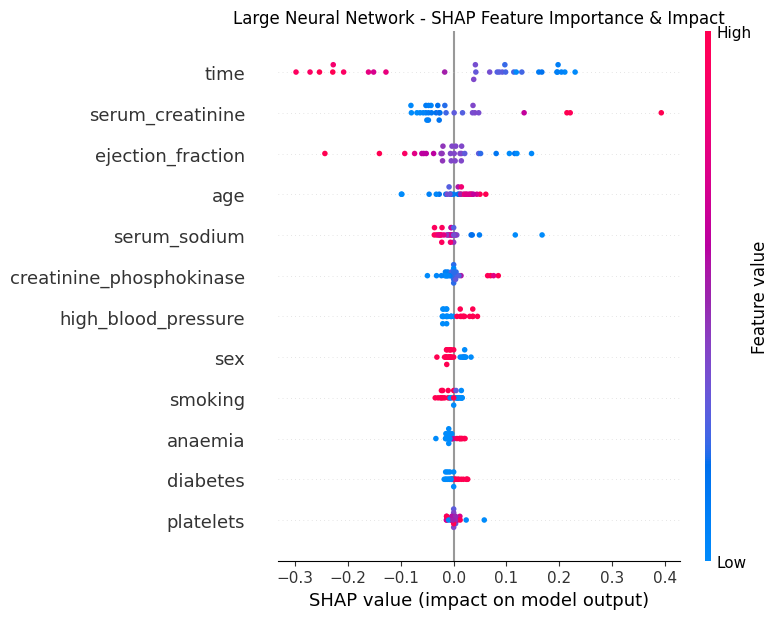


 FINAL COMPREHENSIVE INSIGHTS

 UNIVERSAL CHAMPION ACROSS ALL METHODS:
   'time' dominates with average score: 0.2808

 MULTI-METHOD CONSENSUS (Top 5):
   1. time (Multi-method avg: 0.2808)
   2. ejection_fraction (Multi-method avg: 0.1088)
   3. serum_creatinine (Multi-method avg: 0.1023)
   4. age (Multi-method avg: 0.0754)
   5. serum_sodium (Multi-method avg: 0.0650)

 MODEL-SPECIFIC CHAMPIONS:
   • Small Neural Network: 'time' (0.2183)
   • Medium Neural Network: 'time' (0.1966)
   • Large Neural Network: 'time' (0.2637)
   • CNN: 'time' (0.1537)
   • Random Forest: 'time' (0.1192)
   • Logistic Regression: 'time' (0.2002)

 SAVING COMPREHENSIVE RESULTS

 COMPLETE XAI ANALYSIS FINISHED SUCCESSFULLY!
 All models analyzed with Permutation + SHAP + LIME
 Results saved to: complete_xai_analysis_results.csv


In [67]:
# XAI Analysis - Permutation + SHAP + LIME for ALL Models Including Neural Networks
import shap
from lime import lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("COMPLETE XAI ANALYSIS - SHAP + LIME + PERMUTATION FOR ALL MODELS")
print("="*80)

# INITIALIZATION AND DATA PREP
# =============================================

# Get feature names from the original dataframe
feature_names = [col for col in df.columns if col != 'DEATH_EVENT']
print(f"Feature names: {feature_names}")
print(f"Number of features: {len(feature_names)}")

# Define all models to analyze
all_models = {
    'small_nn': {'model': models['small'], 'type': 'nn', 'name': 'Small Neural Network'},
    'medium_nn': {'model': models['medium'], 'type': 'nn', 'name': 'Medium Neural Network'},
    'large_nn': {'model': models['large'], 'type': 'nn', 'name': 'Large Neural Network'},
    'cnn': {'model': models['cnn'], 'type': 'nn', 'name': 'CNN'},
    'random_forest': {'model': rf_model, 'type': 'tree', 'name': 'Random Forest'},
    'logistic_regression': {'model': logreg, 'type': 'linear', 'name': 'Logistic Regression'}
}

# PERMUTATION IMPORTANCE
# =============================================

def calculate_permutation_importance(model, X, y, feature_names, model_type="nn", model_name="Model"):
    """Calculate permutation importance for any model type"""
    print(f"\nCalculating Permutation Importance - {model_name}")

    try:
        # Create prediction function based on model type
        if model_type == "nn":
            def predict_fn(X):
                return model.predict(X, verbose=0).flatten()
        else:
            def predict_fn(X):
                return model.predict_proba(X)[:, 1]

        # Calculate baseline score
        baseline_pred = predict_fn(X)
        baseline_score = roc_auc_score(y, baseline_pred)
        print(f"   Baseline ROC-AUC: {baseline_score:.4f}")

        # Calculate permutation importance with multiple repetitions for stability
        importances = []
        n_repeats = 3  # Reduced for speed but still stable

        for i, feature in enumerate(feature_names):
            feature_importances = []
            for _ in range(n_repeats):
                X_permuted = X.copy()
                np.random.shuffle(X_permuted[:, i])
                permuted_pred = predict_fn(X_permuted)
                permuted_score = roc_auc_score(y, permuted_pred)
                feature_importances.append(baseline_score - permuted_score)
            importances.append(np.mean(feature_importances))

        # Create importance dataframe
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)

        print(f"  Top 3 features: {', '.join(importance_df.head(3)['feature'].tolist())}")
        return importance_df

    except Exception as e:
        print(f"   Error: {str(e)}")
        return None

# UNIVERSAL SHAP ANALYSIS
# =============================================

def perform_universal_shap_analysis(model, X, feature_names, model_type="nn", model_name="Model"):
    """Perform SHAP analysis for ANY model type including neural networks"""
    print(f"\nSHAP Analysis - {model_name}")

    try:
        # Use appropriate sample sizes for computational efficiency
        if model_type == "nn":
            # Smaller samples for neural networks due to computational cost
            n_background = 50
            n_explain = 30
        else:
            # Larger samples for traditional ML models
            n_background = 100
            n_explain = 50

        X_background = X[:n_background]
        X_explain = X[:n_explain]

        if model_type == "tree":
            # TreeExplainer for Random Forest (fastest)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_explain)
            if isinstance(shap_values, list):
                shap_values = shap_values[1]  # Binary classification positive class

        elif model_type == "linear":
            # LinearExplainer for Logistic Regression
            explainer = shap.LinearExplainer(model, X_background)
            shap_values = explainer.shap_values(X_explain)

        elif model_type == "nn":
            # KernelExplainer for Neural Networks (works for ANY model)
            def predict_fn(x):
                """Prediction function that handles batch processing"""
                if len(x.shape) == 1:
                    x = x.reshape(1, -1)
                predictions = model.predict(x, verbose=0).flatten()
                return predictions

            print(f"  Using KernelExplainer for neural network...")
            explainer = shap.KernelExplainer(predict_fn, X_background)
            shap_values = explainer.shap_values(X_explain, nsamples=100)  # Reduced samples for speed

        # Calculate feature importance from SHAP values
        if shap_values is not None:
            feature_importance = np.abs(shap_values).mean(0)
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'shap_importance': feature_importance
            }).sort_values('shap_importance', ascending=False)

            print(f"   SHAP completed. Top feature: {importance_df.iloc[0]['feature']}")
            return importance_df, shap_values, X_explain

    except Exception as e:
        print(f"   SHAP failed: {str(e)}")
        return None

# LIME ANALYSIS (WORKS FOR ALL MODEL TYPES)
# =============================================

def perform_lime_analysis(model, X, feature_names, model_type="nn", model_name="Model"):
    """Perform LIME analysis for ANY model type"""
    print(f"\n LIME Analysis - {model_name}")

    try:
        # Create prediction function
        if model_type == "nn":
            def predict_fn(x):
                if len(x.shape) == 1:
                    x = x.reshape(1, -1)
                return model.predict(x, verbose=0).flatten()

            def predict_proba_fn(x):
                preds = predict_fn(x)
                return np.column_stack([1 - preds, preds])
        else:
            def predict_proba_fn(x):
                return model.predict_proba(x)

        # Create LIME explainer
        explainer = lime_tabular.LimeTabularExplainer(
            X[:100],  # Training data sample
            feature_names=feature_names,
            class_names=['No Death', 'Death'],
            mode='classification'
        )

        # Explain multiple instances and aggregate
        n_instances = min(10, len(X))  # Explain up to 10 instances
        lime_importances = np.zeros(len(feature_names))

        for i in range(n_instances):
            explanation = explainer.explain_instance(
                X[i],
                predict_proba_fn,
                num_features=len(feature_names)
            )

            # Extract feature importances
            for feature_idx, importance in explanation.as_list():
                # Find the feature index by name
                try:
                    feat_idx = feature_names.index(feature_idx.split('=')[0].strip())
                    lime_importances[feat_idx] += abs(importance)
                except:
                    # Handle categorical features or different naming
                    for j, fname in enumerate(feature_names):
                        if fname in feature_idx:
                            lime_importances[j] += abs(importance)
                            break

        # Average the importances
        lime_importances = lime_importances / n_instances

        # Create importance dataframe
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'lime_importance': lime_importances
        }).sort_values('lime_importance', ascending=False)

        print(f"   LIME completed. Top feature: {importance_df.iloc[0]['feature']}")
        return importance_df

    except Exception as e:
        print(f"   LIME failed: {str(e)}")
        return None

# RUN COMPREHENSIVE ANALYSIS FOR ALL MODELS
# =============================================

print("\n" + "="*80)
print("STEP 1: RUNNING ALL XAI METHODS FOR ALL MODELS")
print("="*80)

# Storage for results
all_permutation_results = {}
all_shap_results = {}
all_lime_results = {}
shap_values_dict = {}

# Run analysis for each model
for model_key, model_info in all_models.items():
    print(f"\n{'='*60}")
    print(f"ANALYZING: {model_info['name'].upper()}")
    print(f"{'='*60}")

    # 1. Permutation Importance (for all models)
    perm_result = calculate_permutation_importance(
        model_info['model'],
        x_test,
        y_test,
        feature_names,
        model_info['type'],
        model_info['name']
    )
    if perm_result is not None:
        all_permutation_results[model_key] = perm_result

    # 2. SHAP Analysis (for all models)
    shap_result = perform_universal_shap_analysis(
        model_info['model'],
        x_test,
        feature_names,
        model_info['type'],
        model_info['name']
    )
    if shap_result is not None:
        shap_df, shap_vals, X_sample = shap_result
        all_shap_results[model_key] = shap_df
        shap_values_dict[model_key] = {'values': shap_vals, 'data': X_sample}

    # 3. LIME Analysis (for all models)
    lime_result = perform_lime_analysis(
        model_info['model'],
        x_test,
        feature_names,
        model_info['type'],
        model_info['name']
    )
    if lime_result is not None:
        all_lime_results[model_key] = lime_result

# CREATE COMPREHENSIVE COMPARISON
# =============================================

print("\n" + "="*80)
print("STEP 2: COMPREHENSIVE CROSS-METHOD COMPARISON")
print("="*80)

# Create master comparison dataframe
comparison_data = {'feature': feature_names}

# Add permutation importance
for model_key, importance_df in all_permutation_results.items():
    model_name = model_key.replace('_', ' ').title()
    comparison_data[f'{model_key}_perm'] = [
        importance_df[importance_df['feature'] == f]['importance'].iloc[0]
        if f in importance_df['feature'].values else 0
        for f in feature_names
    ]

# Add SHAP importance
for model_key, shap_df in all_shap_results.items():
    comparison_data[f'{model_key}_shap'] = [
        shap_df[shap_df['feature'] == f]['shap_importance'].iloc[0]
        if f in shap_df['feature'].values else 0
        for f in feature_names
    ]

# Add LIME importance
for model_key, lime_df in all_lime_results.items():
    comparison_data[f'{model_key}_lime'] = [
        lime_df[lime_df['feature'] == f]['lime_importance'].iloc[0]
        if f in lime_df['feature'].values else 0
        for f in feature_names
    ]

# Create the master dataframe
master_comparison = pd.DataFrame(comparison_data)

# Calculate averages across methods
perm_cols = [col for col in master_comparison.columns if col.endswith('_perm')]
shap_cols = [col for col in master_comparison.columns if col.endswith('_shap')]
lime_cols = [col for col in master_comparison.columns if col.endswith('_lime')]

if perm_cols:
    master_comparison['avg_permutation'] = master_comparison[perm_cols].mean(axis=1)
if shap_cols:
    master_comparison['avg_shap'] = master_comparison[shap_cols].mean(axis=1)
if lime_cols:
    master_comparison['avg_lime'] = master_comparison[lime_cols].mean(axis=1)

# Overall average across all methods
method_avg_cols = [col for col in ['avg_permutation', 'avg_shap', 'avg_lime']
                   if col in master_comparison.columns]
if method_avg_cols:
    master_comparison['overall_average'] = master_comparison[method_avg_cols].mean(axis=1)

# Sort by overall average
if 'overall_average' in master_comparison.columns:
    master_comparison = master_comparison.sort_values('overall_average', ascending=False)
else:
    master_comparison = master_comparison.sort_values('avg_permutation', ascending=False)

# RESULTS SUMMARY
# =============================================

print("\n COMPREHENSIVE RESULTS SUMMARY")
print("="*60)

print(f"\n Successfully completed analysis:")
print(f"   • Permutation Importance: {len(all_permutation_results)}/{len(all_models)} models")
print(f"   • SHAP Analysis: {len(all_shap_results)}/{len(all_models)} models")
print(f"   • LIME Analysis: {len(all_lime_results)}/{len(all_models)} models")

print(f"\n TOP 10 FEATURES - MULTI-METHOD CONSENSUS:")
display_cols = ['feature']
if method_avg_cols:
    display_cols.extend(method_avg_cols)
if 'overall_average' in master_comparison.columns:
    display_cols.append('overall_average')

print(master_comparison[display_cols].head(10).round(4).to_string(index=False))

# Method Agreement Analysis
if len(method_avg_cols) > 1:
    print(f"\n  METHOD AGREEMENT ANALYSIS:")
    method_corr = master_comparison[method_avg_cols].corr()
    print("Correlation between XAI methods:")
    print(method_corr.round(3).to_string())

# Top feature by each method
print(f"\n TOP FEATURE BY EACH METHOD:")
for method_col in method_avg_cols:
    top_feature = master_comparison.loc[master_comparison[method_col].idxmax(), 'feature']
    top_score = master_comparison[method_col].max()
    method_name = method_col.replace('avg_', '').title()
    print(f"   • {method_name}: '{top_feature}' (Score: {top_score:.4f})")

# VISUALIZATIONS
# =============================================

print(f"\n GENERATING VISUALIZATIONS...")

# Plot 1: Method Comparison Heatmap
if len(method_avg_cols) > 1:
    plt.figure(figsize=(12, 8))
    top_features = master_comparison.head(10)
    heatmap_data = top_features[method_avg_cols].T
    heatmap_data.columns = top_features['feature']

    import seaborn as sns
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
                cbar_kws={'label': 'Importance Score'})
    plt.title('Feature Importance Across XAI Methods (Top 10 Features)')
    plt.ylabel('XAI Methods')
    plt.xlabel('Features')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot 2: Overall Rankings
plt.figure(figsize=(12, 6))
if 'overall_average' in master_comparison.columns:
    top_10 = master_comparison.head(10)
    plt.barh(range(len(top_10)), top_10['overall_average'], color='skyblue', alpha=0.8)
    plt.yticks(range(len(top_10)), top_10['feature'])
    plt.xlabel('Overall Average Importance')
    plt.title('Top 10 Features - Multi-Method Consensus Ranking')
    plt.gca().invert_yaxis()

    # Add value labels
    for i, v in enumerate(top_10['overall_average']):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

# Plot 3: SHAP Summary Plots (if available)
if shap_values_dict:
    print(f"\n SHAP SUMMARY PLOTS:")
    for model_key, shap_data in list(shap_values_dict.items())[:3]:  # Show first 3
        model_name = all_models[model_key]['name']
        try:
            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_data['values'], shap_data['data'],
                            feature_names=feature_names, show=False)
            plt.title(f'{model_name} - SHAP Feature Importance & Impact')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"   Could not create SHAP plot for {model_name}: {str(e)}")

# FINAL INSIGHTS
# =============================================

print(f"\n FINAL COMPREHENSIVE INSIGHTS")
print("="*60)

if 'overall_average' in master_comparison.columns:
    top_feature = master_comparison.iloc[0]['feature']
    top_score = master_comparison.iloc[0]['overall_average']
    print(f"\n UNIVERSAL CHAMPION ACROSS ALL METHODS:")
    print(f"   '{top_feature}' dominates with average score: {top_score:.4f}")

print(f"\n MULTI-METHOD CONSENSUS (Top 5):")
for i, (_, row) in enumerate(master_comparison.head(5).iterrows(), 1):
    feature = row['feature']
    if 'overall_average' in row:
        score = row['overall_average']
        print(f"   {i}. {feature} (Multi-method avg: {score:.4f})")

# Model-specific champions
print(f"\n MODEL-SPECIFIC CHAMPIONS:")
for model_key, perm_df in all_permutation_results.items():
    model_name = all_models[model_key]['name']
    top_feature = perm_df.iloc[0]['feature']
    top_score = perm_df.iloc[0]['importance']
    print(f"   • {model_name}: '{top_feature}' ({top_score:.4f})")

print(f"\n SAVING COMPREHENSIVE RESULTS")
master_comparison.to_csv('complete_xai_analysis_results.csv', index=False)

print(f"\n" + "="*80)
print(" COMPLETE XAI ANALYSIS FINISHED SUCCESSFULLY!")
print(" All models analyzed with Permutation + SHAP + LIME")
print(" Results saved to: complete_xai_analysis_results.csv")
print("="*80)